Chance of not being broke at age 60 was 100.0 %
Median net asset value at  60  was  462030871.37
Median net worth at  60  was  455030871.37
5% of the annual asset returns were worse than  -18.76 %


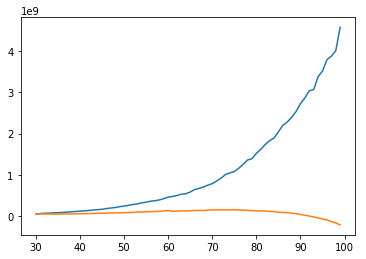

In [4]:
import numpy
import matplotlib.pyplot as plt
#import yfinance as yf


age = 30 #User Inputs Their Age
portfolioMeanReturn = 0.07 #Portfolio Mean Return is calculated from the weighted average historical return of all the assets that the user has included in their portfolio. Here we're just hard inputting it for the demo.
portfolioStandardDeviation = 0.17 #Portfolio Standard Deviaiton is calculated as per the googledocs I showed and takes into account the correlation of the assets in their portfolio. Here we will just hard input it for the demo.
startingAssets = 47000000



simyears = 100 - age #We are hard-coding 100 years of life. So the years to simulate are the users remaining years of life.
maxsimulations = 1000
inflation = 0.02

#Here is where we specify the age at which we take a snapshot of how the user is doing.
#i.e. number of succesful trials out of maxsimulations
#median net worth
TestingAge = 60
cashFlows = {}
assetflow  = {}
liabilityflow = {}



def cashflowinput(yearstart,yearend,growthrate,amount):
    for i in range(simyears):
        if yearstart <= i <= yearend:
            if i in cashFlows.keys():
                cashFlows[i] = cashFlows[i] + (amount * ((1+growthrate)**i))
            else:
                cashFlows[i] = amount * ((1+growthrate)**i)

def payment(tenor,interestrate,loanamount,balloonpct):
    balloonamount = loanamount*balloonpct
    growth = 1 + interestrate
    numerator = loanamount*(growth**tenor)-balloonamount
    denominator = 0
    for i in range(tenor):
        year = i
        denominator = denominator + growth**year
    pmt = numerator/denominator
    return pmt

def financedpurchase(itemValue,loanSize,interestRate,balloonPercent,tenor,yearpurchased,isinvestment):
    balloonAmount = balloonPercent * loanSize
    pmt = payment(tenor,interestRate,loanSize,balloonPercent)
    yearended = yearpurchased + tenor + 1
    #amend cashflows for interest and principle payments
    cashflowinput(yearpurchased,yearended,0,-pmt)
    #amend cashflows for balloon payment
    cashflowinput(yearended,yearended,0,-balloonAmount)
    assetflow[yearpurchased+1] = itemValue
    #Liabilityamount each year
    tloanvalue = loanSize
    for year in range(yearpurchased,yearended):
        liabilityamt  =  loanSize
        for t in range(year):
            liabilityamt = liabilityamt*(1+interestRate)-pmt
        if year in liabilityflow.keys():
            liabilityflow[year] = liabilityflow[year] + liabilityamt
        else:
            liabilityflow[year] = liabilityamt

cashflowinput(0,30,0.03,100000*12) # Salary

cashflowinput(0,69,0.05,-80000*12) # Expenses

financedpurchase(15000000,7000000,0.05,1,30,0,0) # Home Purchase

simDict = {}

#this is a list of all the returns simulated. it will be simyears * maxsimulations long.
#We will use it to calculate the worth 5th percentile of returns the user experiences.

allreturns =[]

#This is where we actually generate the simulation data.
for sim in range(maxsimulations):
    NAV = {} #initiate an empty dictionary of NAV for a simulation.
    NAV[0]=startingAssets
    simReturn = {}
    for i in range(1,simyears):
        yearReturn = numpy.random.lognormal(portfolioMeanReturn,portfolioStandardDeviation) #generating a rate of return for the yaer
        simReturn[i]= yearReturn
        allreturns.append(yearReturn)
        specialasset = 0
        if i in assetflow.keys():
            specialasset = assetflow[i]
        NAV[i] = (NAV[i-1]+cashFlows[i])*simReturn[i] + specialasset #Generating a NAV for the year based on cashflow, previous years NAV, and the generated rate of return.
    simDict[sim] = NAV #adding it to the dictionary of simulations.

# Outputs

MedianData = []
LowDecile = []
for year in range(simyears):
    NAVforYear = []
    for sim in range(maxsimulations):
        NAVforYear.append(simDict[sim][year])
    MedianData.append(numpy.median(NAVforYear))
    LowDecile.append(numpy.percentile(NAVforYear, 10))

plt.plot(range(age, age + simyears), MedianData)
plt.plot(range(age, age + simyears), LowDecile)
TestYear = TestingAge - age

success = 0.0
fail = 0.0
TestYearNAV = []
for i in simDict:
    TestYearNAV.append(simDict[i][TestYear])
    if simDict[i][TestYear] > 0:
        success = success + 1
    else:
        fail = fail + 1
    successrate = success / (success + fail)
testingliability = 0
if (TestingAge-age) in liabilityflow.keys():
    testingliability = liabilityflow[TestingAge-age]
else:
    testingliability = 0

print ("Chance of not being broke at age", TestingAge, "was", round(successrate * 100, 2), "%")
print ("Median net asset value at ", TestingAge, " was ", round(numpy.median(TestYearNAV), 2))
print ("Median net worth at ",TestingAge," was ", round(numpy.median(TestYearNAV), 2)-testingliability)
print ("5% of the annual asset returns were worse than ", round((numpy.percentile(allreturns, 5) - 1) * 100, 2), "%")